In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, transform_bounding_box_to_sensor_coord_and_get_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,extract_other_sensor_token,\
transform_box_from_world_to_sensor_coordinates,get_box_yaw_angle_in_world_coords,get_sensor_to_world_transform_matrix
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion,Box
from lyft_dataset_sdk.utils.geometry_utils import points_in_box,transform_matrix

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d

SystemExit: 2

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [105]:

from parse_pointnet_output import rotate_pc_along_y,get_heading_angle,get_size,get_center_in_sensor_coord

usage: ipykernel_launcher.py [-h] [--data_path DATA_PATH]
                             [--artifact_path ARTIFACT_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/kanhua/Library/Jupyter/runtime/kernel-af8c1d63-6c06-4fbe-8ef0-3293197f9170.json


SystemExit: 2

In [106]:
from provider import FrustumDataset

In [107]:
lyft_data_file="/Users/kanhua/Dropbox/Programming/lyft-3d-main/artifact/lyft_val.pickle"
kitti_data_file="/Users/kanhua/Downloads/frustum-pointnets/kitti/frustum_carpedcyc_val.pickle"
NUM_POINT=1024

In [108]:
dataset=FrustumDataset(npoints=NUM_POINT,split='val',
                       from_rgb_detection=False,
                    overwritten_data_path=lyft_data_file,one_hot=True,rotate_to_center=True)

In [109]:
dataset[1]

(array([[ 2.1362759e-01,  1.3365035e+00,  2.5910990e+01,  2.0000000e-01],
        [-2.3306778e-01,  1.2980223e+00,  2.0034061e+01,  2.0000000e-01],
        [-6.2499371e+00,  3.5091722e+00,  1.8836690e+02,  2.0000000e-01],
        ...,
        [ 3.8718879e-01,  7.4819475e-01,  9.9725676e+00,  2.0000000e-01],
        [ 1.9048738e-01,  6.4742339e-01,  2.6181988e+01,  2.0000000e-01],
        [ 1.7592777e-01,  1.7152271e+00,  2.5810581e+01,  2.0000000e-01]],
       dtype=float32),
 array([ True, False, False, ..., False,  True,  True]),
 array([ 0.0817595 ,  1.35748782, 27.71142014]),
 9,
 0.12832227093216186,
 0,
 array([0.0198836 , 0.1694326 , 0.19636809]),
 -0.13009332397769513,
 array([1., 0., 0.]))

In [110]:
a=dataset[1]

In [111]:
len(a)

9

In [112]:
type(dataset.input_list)

list

In [113]:
pointset=a[0]
seg=a[1]
box3d_center=a[2]
rot_angle=a[7]

In [114]:
box3d_center

array([ 0.0817595 ,  1.35748782, 27.71142014])

In [115]:
rot_angle

-0.13009332397769513

In [116]:
def rad2deg(radius):
    return radius*180/np.pi

In [117]:
rad2deg(rot_angle)

-7.453798406750006

In [118]:
seg=seg.astype(bool)

In [119]:
pointset_before_transformation=dataset.input_list[1]

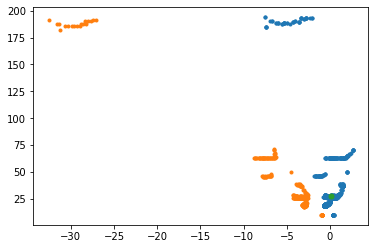

In [120]:
plt.plot(pointset[:,0],pointset[:,2],'.')
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
#plt.plot(pointset[seg,0],pointset[seg,2],'.')
plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)

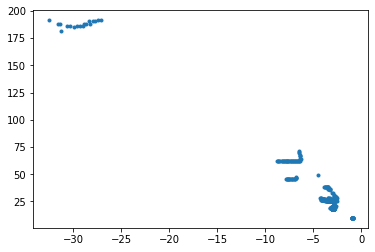

In [121]:
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')

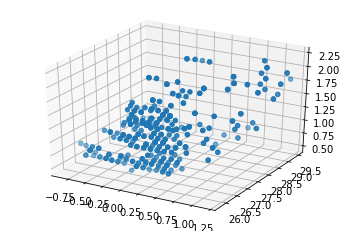

In [122]:
sel_pointset=pointset[seg,:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pointset[:,0], pointset[:,2], pointset[:,1])
ax.scatter(sel_pointset[:,0],sel_pointset[:,2],sel_pointset[:,1])

## See inference results

In [123]:
from path_setting import MODEL_PATH_1

import tensorflow as tf
import importlib
from train_util import get_batch
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER
# Set training configurations
BATCH_SIZE = 32
MODEL_PATH = MODEL_PATH_1 
GPU_INDEX = 0
MODEL = importlib.import_module("frustum_pointnets_v1")
NUM_CLASSES = 2
NUM_CHANNEL = 4

In [124]:
# functions excerpted from frustum-pointnet test.py
def get_session_and_ops(batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:' + str(GPU_INDEX)):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                MODEL.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = MODEL.get_model(pointclouds_pl, one_hot_vec_pl,
                                         is_training_pl)
            loss = MODEL.get_loss(labels_pl, centers_pl,
                                  heading_class_label_pl, heading_residual_label_pl,
                                  size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops
def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape) - 1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape) - 1, keepdims=True)
    return probs


def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0] % batch_size == 0
    num_batches = int(pc.shape[0] / batch_size)
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],))  # 3D box score

    ep = ops['end_points']
    for i in range(num_batches):
        feed_dict = { \
            ops['pointclouds_pl']: pc[i * batch_size:(i + 1) * batch_size, ...],
            ops['one_hot_vec_pl']: one_hot_vec[i * batch_size:(i + 1) * batch_size, :],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                      ep['heading_scores'], ep['heading_residuals'],
                      ep['size_scores'], ep['size_residuals']],
                     feed_dict=feed_dict)

        logits[i * batch_size:(i + 1) * batch_size, ...] = batch_logits
        centers[i * batch_size:(i + 1) * batch_size, ...] = batch_centers
        heading_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_scores
        heading_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_residuals
        size_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_size_scores
        size_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:, :, 1]  # BxN
        batch_seg_mask = np.argmax(batch_logits, 2)  # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1)  # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask, 1)  # B,
        heading_prob = np.max(softmax(batch_heading_scores), 1)  # B
        size_prob = np.max(softmax(batch_size_scores), 1)  # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i * batch_size:(i + 1) * batch_size] = batch_scores
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1)  # B
    size_cls = np.argmax(size_logits, 1)  # B
    heading_res = np.array([heading_residuals[i, heading_cls[i]] \
                            for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i, size_cls[i], :] \
                          for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
           size_cls, size_res, scores

In [125]:
sess, ops = get_session_and_ops(batch_size=BATCH_SIZE, num_point=NUM_POINT)

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from ./log_v1/model.ckpt


In [126]:
result_dir=None
TEST_DATASET=dataset

## Proecedures of test()
ps_list = []
seg_list = []
segp_list = []
center_list = []
heading_cls_list = []
heading_res_list = []
size_cls_list = []
size_res_list = []
rot_angle_list = []
score_list = []

test_idxs = np.arange(0, len(TEST_DATASET))
batch_size = BATCH_SIZE
num_batches = int(len(TEST_DATASET) / batch_size)
assert ((len(TEST_DATASET) % int(batch_size)) == 0)

sess, ops = get_session_and_ops(batch_size=batch_size, num_point=NUM_POINT)
correct_cnt = 0
for batch_idx in range(num_batches):
    #print('batch idx: %d' % (batch_idx))
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_data, batch_label, batch_center, \
    batch_hclass, batch_hres, batch_sclass, batch_sres, \
    batch_rot_angle, batch_one_hot_vec = \
        get_batch(TEST_DATASET, test_idxs, start_idx, end_idx,
                  NUM_POINT, NUM_CHANNEL)

    batch_output, batch_center_pred, \
    batch_hclass_pred, batch_hres_pred, \
    batch_sclass_pred, batch_sres_pred, batch_scores = \
        inference(sess, ops, batch_data,
                  batch_one_hot_vec, batch_size=batch_size)

    correct_cnt += np.sum(batch_output == batch_label)

    for i in range(batch_output.shape[0]):
        ps_list.append(batch_data[i, ...])
        seg_list.append(batch_label[i, ...])
        segp_list.append(batch_output[i, ...])
        center_list.append(batch_center_pred[i, :])
        heading_cls_list.append(batch_hclass_pred[i])
        heading_res_list.append(batch_hres_pred[i])
        size_cls_list.append(batch_sclass_pred[i])
        size_res_list.append(batch_sres_pred[i, :])
        rot_angle_list.append(batch_rot_angle[i])
        score_list.append(batch_scores[i])

print("Segmentation accuracy: %f" % \
      (correct_cnt / float(batch_size * num_batches * NUM_POINT)))

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from ./log_v1/model.ckpt


/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


Segmentation accuracy: 0.839310


In [127]:
len(TEST_DATASET)

64

In [128]:
score_list[0]

-1.7161473923235362

In [129]:
segp_list[0]

array([0, 1, 0, ..., 0, 1, 0])

In [130]:
seg_list[0]

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

## Check the results

In [131]:
data_idx=1
np.sum(seg_list[data_idx]==segp_list[data_idx])/seg_list[data_idx].shape

array([0.77734375])

In [132]:
np.sum(seg_list[data_idx])

457

In [133]:
np.sum(segp_list[data_idx])

383

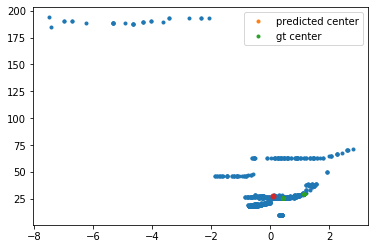

In [134]:
pointset=ps_list[data_idx]
box3d_center=dataset[data_idx][2]
plt.plot(pointset[:,0],pointset[:,2],'.')
#plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
plt.plot(pointset[segp_list[data_idx],0],pointset[segp_list[data_idx],2],'.',label='predicted center')
plt.plot(pointset[seg_list[data_idx],0],pointset[seg_list[data_idx],2],'.',label='gt center')
plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)
plt.legend()
#plt.ylim([4,6])
#plt.xlim([-1,1])

## compare center

predicted center coordinate

In [135]:
pred_center=center_list[data_idx]
pred_center

array([-0.09721507,  1.14677489, 27.57660484])

gt center coordinate

In [136]:
gt_center=dataset[data_idx][2]
gt_center

array([ 0.0817595 ,  1.35748782, 27.71142014])

### Convert center back to the world coordinates

In [137]:
rot_angle=dataset[data_idx][7]

In [138]:
gt_center

array([ 0.0817595 ,  1.35748782, 27.71142014])

In [139]:
gt_center_before_rotation=rotate_pc_along_y(np.expand_dims(gt_center,0),rot_angle=-rot_angle).squeeze()
gt_center_before_rotation

NameError: name 'rotate_pc_along_y' is not defined

In [ ]:
rotate_pc_along_y(np.expand_dims(gt_center_before_rotation,0),rot_angle=rot_angle).squeeze()

In [ ]:
gt_center_before_rotation

## compare heading

In [ ]:
heading_cls_list[data_idx]

In [ ]:
heading_res_list[data_idx]

### predicted heading angle

in radius

In [ ]:
from provider import class2angle
pred_angle_radius=class2angle(heading_cls_list[data_idx],heading_res_list[data_idx],NUM_HEADING_BIN)
pred_angle_radius

in degree

In [ ]:
pred_angle_degree=pred_angle_radius*180/np.pi
pred_angle_degree

In [ ]:
## Plus rotation angle

In [ ]:
pred_angle_radius=class2angle(heading_cls_list[data_idx],
                              heading_res_list[data_idx],NUM_HEADING_BIN)+dataset[data_idx][7]
pred_angle_radius

In [ ]:
dataset[data_idx][3]

In [ ]:
dataset.id_list[data_idx]

### heading angle ground truth:

In [140]:
gt_angle_radius=dataset.heading_list[data_idx]
gt_angle_radius

-1.57256737984043

In [141]:
gt_angle_degree=gt_angle_radius*180/np.pi
gt_angle_degree

-90.10147386480287

(array([ 1.,  0.,  0.,  0.,  1., 18., 33.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  5.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-2.20223437, -2.09836852, -1.99450267, -1.89063682, -1.78677096,
        -1.68290511, -1.57903926, -1.4751734 , -1.37130755, -1.2674417 ,
        -1.16357585, -1.05970999, -0.95584414, -0.85197829, -0.74811243,
        -0.64424658, -0.54038073, -0.43651487, -0.33264902, -0.22878317,
        -0.12491732, -0.02105146,  0.08281439,  0.18668024,  0.2905461 ,
         0.39441195,  0.4982778 ,  0.60214366,  0.70600951,  0.80987536,
         0.91374121,  1.01760707,  1.12147292,  1.22533877,  1.32920463,
         1.43307048,  1.53693633,  1.64080219,  1.74466804,  1.84853389,
         1.95239974,  2.0562656 ,  2.16013145,  2.2639973 ,  2.36786316,
         2.47172901,  2.57559486,  2.67946072,  2.78332657,

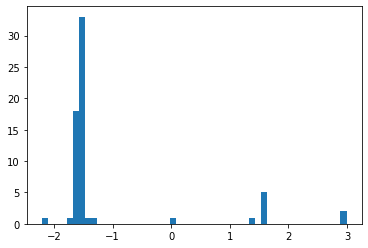

In [142]:
plt.hist(dataset.heading_list,bins=50)

## Compare all heading angles

In [143]:
type(heading_cls_list)

list

In [144]:
all_pred_angle_radius=np.empty(len(heading_cls_list))
for idx in range(len(heading_cls_list)):
    pred_angle_radius=class2angle(heading_cls_list[idx],heading_res_list[idx],NUM_HEADING_BIN)+dataset[idx][7]
    all_pred_angle_radius[idx]=pred_angle_radius

In [145]:
all_gt_angle_raidus=np.array(dataset.heading_list)

Text(0, 0.5, 'predicted heading angle')

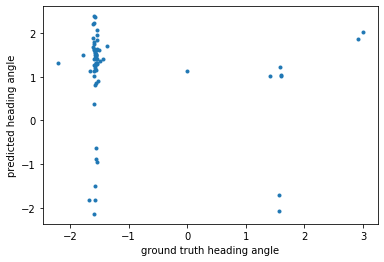

In [146]:
## plot in 2D
plt.plot(all_gt_angle_raidus,all_pred_angle_radius,'.')
plt.xlabel("ground truth heading angle")
plt.ylabel("predicted heading angle")

It seems the heading angle is of some classes are not correct.

## Compare box

In [147]:
from provider import class2size

predicted box size

In [148]:
class2size(size_cls_list[data_idx],size_res_list[data_idx])

array([4.65071485, 1.78171392, 1.73756158])

ground truth of box size

In [149]:
dataset.size_list[data_idx]

array([3.903, 1.798, 1.722])

## Convert the prediction back to world coordinates

extract the token

In [150]:
train_df=parse_train_csv()

NameError: name 'parse_train_csv' is not defined

In [151]:
train_df.head(1)

NameError: name 'train_df' is not defined

In [152]:
sample_token=train_df.iloc[data_idx,0]
sample_token

NameError: name 'train_df' is not defined

### Convert ground truth box back to world coordiantes

In [153]:
gt_angle

NameError: name 'gt_angle' is not defined

In [154]:
gt_size=dataset.size_list[data_idx]
gt_angle=dataset.heading_list[data_idx]
l,w,h=gt_size

first_rot=Quaternion(axis=[1,0,0],angle=np.pi/2)
second_rot=Quaternion(axis=[0,-1,0],angle=-gt_angle)
gt_box_in_sensor_coord=Box(center=gt_center_before_rotation,size=[w,l,h],
                             orientation=second_rot*first_rot)


#gt_box_in_sensor_coord.rotate(third_rot)

NameError: name 'gt_center_before_rotation' is not defined

In [155]:
gt_box_in_sensor_coord

NameError: name 'gt_box_in_sensor_coord' is not defined

In [156]:
cam_to_world_mtx=get_sensor_to_world_transform_matrix(sensor_type='CAM_FRONT',
                                                      sample_token=train_df.iloc[dataset.id_list[data_idx],0])

NameError: name 'get_sensor_to_world_transform_matrix' is not defined

In [157]:
gt_center_before_rotation_h=np.concatenate((gt_center_before_rotation,np.ones(1)))
gt_center_before_rotation_h

NameError: name 'gt_center_before_rotation' is not defined

In [158]:
np.dot(cam_to_world_mtx,np.transpose(gt_center_before_rotation_h))

NameError: name 'cam_to_world_mtx' is not defined

In [159]:
gt_box_in_sensor_coord

NameError: name 'gt_box_in_sensor_coord' is not defined

In [160]:
gt_box_in_sensor_coord_corners=gt_box_in_sensor_coord.corners()
gt_box_in_sensor_coord_corners
print(gt_box_in_sensor_coord_corners.shape)

NameError: name 'gt_box_in_sensor_coord' is not defined

In [161]:
gt_box_in_sensor_coord_corners_h=np.concatenate((gt_box_in_sensor_coord_corners,np.ones((1,8))),axis=0)
gt_box_in_sensor_coord_corners_h.shape

NameError: name 'gt_box_in_sensor_coord_corners' is not defined

In [162]:
corners_in_world_coord=np.dot(cam_to_world_mtx,gt_box_in_sensor_coord_corners_h)
corners_in_world_coord

NameError: name 'cam_to_world_mtx' is not defined

In [163]:
gt_box_in_world_coord=convert_box_to_world_coord(gt_box_in_sensor_coord,
                                                 sensor_type='CAM_FRONT',sample_token=train_df.iloc[data_idx,0])
gt_box_in_world_coord

NameError: name 'convert_box_to_world_coord' is not defined

In [164]:
gt_box_in_world_coord.orientation.yaw_pitch_roll

NameError: name 'gt_box_in_world_coord' is not defined

In [165]:
get_box_yaw_angle_in_world_coords(gt_box_in_world_coord)+np.pi

NameError: name 'get_box_yaw_angle_in_world_coords' is not defined

In [166]:
_,gt_box=get_train_data_sample_token_and_box(dataset.id_list[data_idx],train_df)
gt_box

NameError: name 'get_train_data_sample_token_and_box' is not defined

NameError: name 'gt_box' is not defined

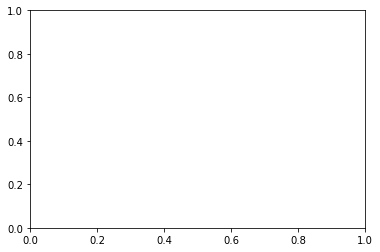

In [167]:
fig,ax=plt.subplots()
view_mtx=np.eye(2)
gt_box.render(ax,view=view_mtx)
gt_box_in_world_coord.render(ax,view=view_mtx)

In [ ]:
fig,ax=plt.subplots()
view_mtx=np.array([[0,1,0],[0,0,1],[0,0,0]])
gt_box.render(ax,view=view_mtx)
gt_box_in_world_coord.render(ax,view=view_mtx)

In [168]:
gt_box.corners()

NameError: name 'gt_box' is not defined

In [ ]:
gt_box_in_world_coord.corners()

In [ ]:
get_box_yaw_angle_in_world_coords(gt_box_in_world_coord)

In [ ]:
from prepare_lyft_data import get_box_corners_yaw_angle_in_world_coords
get_box_corners_yaw_angle_in_world_coords(corners_in_world_coord[0:3,:])

### Convert predicted box back to world coordinates

In [ ]:
pred_size=class2size(size_cls_list[data_idx],size_res_list[data_idx])
center=np.array(center_list[data_idx])
rotated_back_center=rotate_pc_along_y(np.expand_dims(center,0),-rot_angle).squeeze()
l,w,h=class2size(size_cls_list[data_idx],size_res_list[data_idx])
pred_angle_radius=class2angle(heading_cls_list[data_idx],
                              heading_res_list[data_idx],NUM_HEADING_BIN)+dataset[data_idx][7]
pred_box_in_sensor_coord=Box(center=rotated_back_center,size=[h,l,w],
                             orientation=Quaternion(axis=[0,-1,0],angle=pred_angle_radius+np.pi))

In [ ]:
center

In [ ]:
box_in_world_coord=convert_box_to_world_coord(pred_box_in_sensor_coord,
                           sensor_type='CAM_FRONT',sample_token=train_df.iloc[data_idx,0])
box_in_world_coord

In [ ]:
train_df.iloc[data_idx,:]

Calculate the yaw angle in world coordinates

In [ ]:
get_box_yaw_angle_in_world_coords(box_in_world_coord)